# clean notebook for generating scripts, submitting scripts, and plotting results

## helper funcs

In [1]:
# train/test csv file read
# automated multi-round submission & eval??? averaging??

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import subprocess
from pathlib import Path
from itertools import product


def create_file_with_contents(file_path, contents):
    try:
        with open(file_path, 'w') as file:
            file.write(contents)
    except Exception as e:
        print(f"Error: {e}")
        
def submit_job(script_path):
    output = subprocess.run(f'LLsub {script_path}', shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    return output.stdout, output.stderr

def verify_execution(log_path):
    with open(log_path) as file:
        last_line = ''
        for line in file:
            last_line = line
        return ('job done!' in last_line)
    
def verify_multiple_execution(log_paths):
    failed = [x for x in log_paths if not verify_execution(x)]
    if failed:
        print(f'failed scripts: {failed}')
    else:
        print('all scripts success!')
        
def prep_additional_training(source_dir, target_dir, source_e):
    # copy source model-e.pth into target model-0.pth, copy related part of train_results.csv
    
    os.system(f'(head -{source_e+2} {source_dir}/train_results.csv) >> {target_dir}/train_results.csv')
    # copy relevant model *.pth file
    Path(f'{target_dir}/models').mkdir(parents=True, exist_ok=True)
    shutil.copy(f'{source_dir}/models/model-{source_e}.pth', f'{target_dir}/models/model-0.pth')

In [45]:
prep_additional_training('pareto/single_ring/from_scratch/0.7_1old', 'pareto/single_ring/from_scratch/0.7_1', 170)

## single ring

#### helper funcs

In [2]:
single_folder = 'pareto/single_ring'
single_num_runs = 3 #number of training runs for each experiment

def single_ring_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        worker_kwargs=[{'circumference':250}], 
        n_workers=40,
        n_rollouts_per_step=40, 
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=5000,
        global_reward=True,
        n_steps=50,
        alg='TRPO',
        use_critic=False,
        gamma=0.9995,
        beta=0,
        scale_ttc=1,
        scale_pet=1,
        scale_drac=1,
        seed_np=False,
        seed_torch=False,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "worker_kwargs={worker_kwargs}" "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "warmup_steps={warmup_steps}"'''
f''' "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "global_reward={global_reward}" "n_steps={n_steps}" "alg='{alg}'" "use_critic={use_critic}" "gamma={gamma}" "beta={beta}"'''
f''' "scale_ttc={scale_ttc}" "scale_pet={scale_pet}" "scale_drac={scale_drac}" "seed_np={seed_np}" "seed_torch={seed_torch}"'''
                  )
    return script_text

def single_ring_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        e='50',
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=1000,
        circumference=250,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
        scale_ttc=1,
        scale_pet=1,
        scale_drac=1,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "e={e}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "circumference={circumference}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}"'''
f''' "scale_ttc={scale_ttc}" "scale_pet={scale_pet}" "scale_drac={scale_drac}"'''
                  )
    return script_text


##### find seed

In [3]:
import random
single_ring_seed_dir = f'{single_folder}/seeding'
Path(f'{single_ring_seed_dir}').mkdir(parents=True, exist_ok=True)

def seed_single(torch_seeds, np_seeds):
    output_logs = []
    for i in range(8):
        torch_seed, np_seed = torch_seeds[i], np_seeds[i]
        cur_dir = f'{single_ring_seed_dir}/beta0.5_SSM1_torch{torch_seed}_np{np_seed}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=0.5, n_steps=100, seed_torch=torch_seed, seed_np=np_seed)
        train_script_path = f'{cur_dir}/traintorch{torch_seed}_np{np_seed}_beta0.5_SSM1_.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [4]:
random_torch_seeds = [random.randint(0, 1000000) for _ in range(8)]

seed_seq = np.random.SeedSequence()
random_np_seeds = seed_seq.generate_state(8)

print(random_torch_seeds)
print(random_np_seeds)

outputs = seed_single(random_torch_seeds, random_np_seeds)
print(outputs)

[393074, 106619, 778321, 423228, 14606, 731208, 60365, 203490]
[3451991332 1228644375 2109944452 4202972154 4191455537 2140084723
 3618751158  488264084]
['pareto/single_ring/seeding/beta0.5_SSM1_torch393074_np3451991332/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch106619_np1228644375/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch778321_np2109944452/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch423228_np4202972154/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch14606_np4191455537/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch731208_np2140084723/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch60365_np3618751158/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch203490_np488264084/train.log']


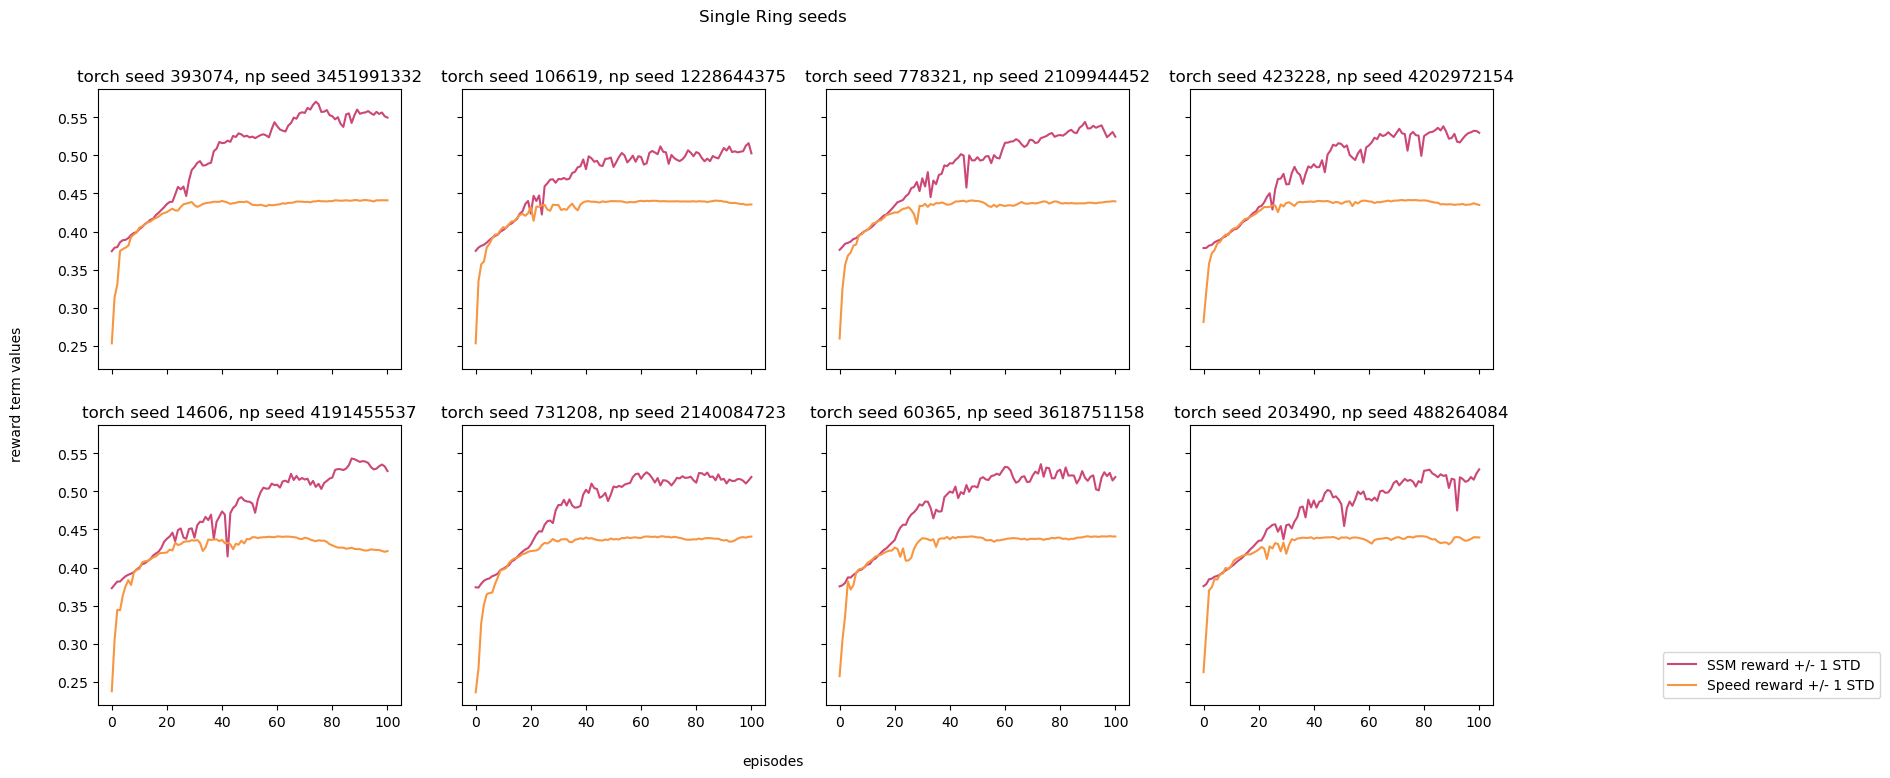

In [5]:
# train progress: plot rewards for each seed

fig, axs = plt.subplots(2, 4, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (5 - 1)) for i in range(5)] # split plasma into 12 colors

random_torch_seeds=[393074, 106619, 778321, 423228, 14606, 731208, 60365, 203490]
random_np_seeds=[3451991332, 1228644375, 2109944452, 4202972154, 4191455537, 2140084723, 3618751158, 488264084]

for i in range(8):
    torch_seed, np_seed = random_torch_seeds[i], random_np_seeds[i]
    cur_dir = f'{single_ring_seed_dir}/beta0.5_SSM1_torch{torch_seed}_np{np_seed}'
    train_csv = f'{cur_dir}/train_results.csv'
    if os.path.exists(train_csv):
        train_df = pd.read_csv(train_csv)
        ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
        speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
        drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
        ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

        x = np.arange(len(speed_y))
    
        # pet_y = train_df['pet_mean']
        # ax.plot(x, pet_y, color='orange', label='pet')

        ax = axs_flat[i]
        ax.set_title(f'torch seed {torch_seed}, np seed {np_seed}')
        # ax.plot(x, ttc_y, color=colors[0], label=f'TTC run{i}')
        # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2)
        # ax.plot(x, drac_y, color=colors[1], label=f'-1 * DRAC run{i}')
        # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='purple', alpha=0.2)
        ax.plot(x, ssm_y, color=colors[2], label=f'SSM reward +/- 1 STD')
        # ax.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='red', alpha=0.2)
        ax.plot(x, speed_y, color=colors[3], label=f'Speed reward +/- 1 STD')
        # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2)

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Single Ring seeds')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()

##### Scaling SSM reward term (from scratch, TTC and DRAC)

In [7]:
single_ring_scaling_SSM_dir = f'{single_folder}/ssm_scaling'
Path(f'{single_ring_scaling_SSM_dir}').mkdir(parents=True, exist_ok=True)
scale_values=[s/10.0 for s in range(1, 11)]
run_nums=np.arange(single_num_runs)
seed_np = 1228644375
seed_torch = 106619

In [8]:
# testing scaling ssm term appropriately, between [0.1, 1]

def scale_SSM_single(i_scale_pairs):
    output_logs = []
    for i, scale in i_scale_pairs:
        cur_dir = f'{single_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train0.5_SSM{scale}_run{i}.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=0.5, scale_ttc=scale, scale_drac=scale, n_steps=100, seed_np=seed_np, seed_torch=seed_torch)
        train_script_path = f'{cur_dir}/train0.5_SSM{scale}_run{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [9]:
train_outputs = scale_SSM_single(product(run_nums, scale_values))
print(train_outputs)

['pareto/single_ring/ssm_scaling/beta0.5_SSM0.1_run0/train0.5_SSM0.1_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.2_run0/train0.5_SSM0.2_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.3_run0/train0.5_SSM0.3_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.4_run0/train0.5_SSM0.4_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.5_run0/train0.5_SSM0.5_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.6_run0/train0.5_SSM0.6_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.7_run0/train0.5_SSM0.7_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.8_run0/train0.5_SSM0.8_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.9_run0/train0.5_SSM0.9_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM1.0_run0/train0.5_SSM1.0_run0.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.1_run1/train0.5_SSM0.1_run1.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.2_run1/train0.5_SSM0.2_run1.log', 'pareto/single_ring/ssm_scaling/beta0.5_SSM0.3_run1

In [39]:
scale_SSM_single([(2, 0.5)])
# rm -rf 0.2, 1
# rm -rf 0.1, 2

['pareto/single_ring/ssm_scaling/beta0.5_SSM0.5_run2/train0.5_SSM0.5_run2.log']

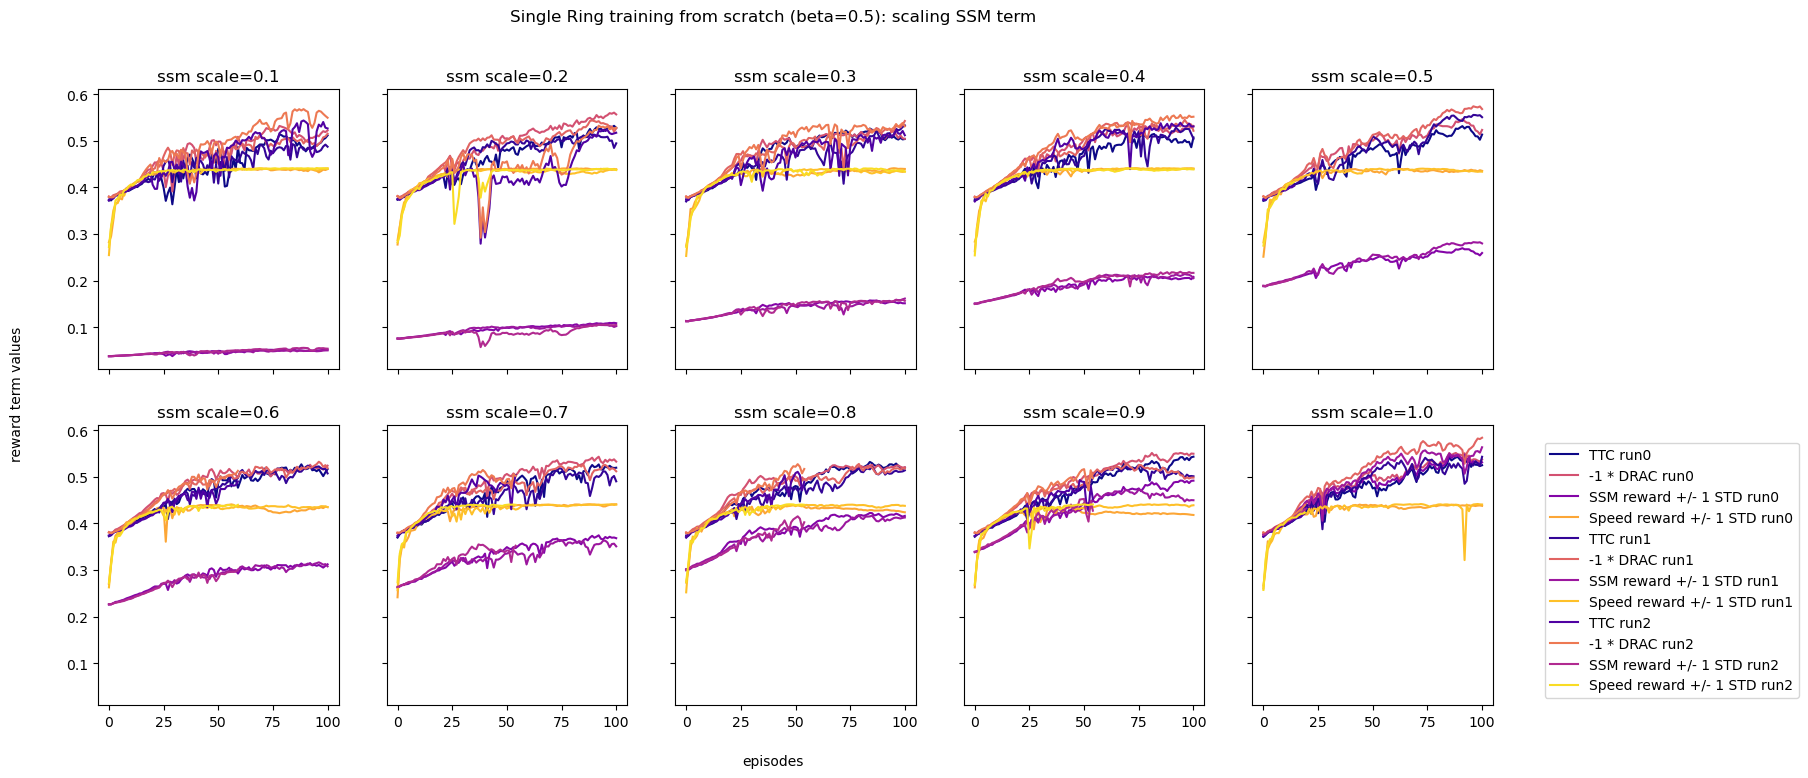

In [45]:
# train progress: plot reward terms for each run of each ssm term scale value

# ssm_term = scale*(ttc - drac)/2
# reward_func = (0.5)*speed_reward + (0.5)*ssm_term

fig, axs = plt.subplots(2, 5, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (16 - 1)) for i in range(16)] # split plasma into 12 colors

for i, scale in product(run_nums, scale_values):
    cur_dir = f'{single_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
    train_csv = f'{cur_dir}/train_results.csv'
    if os.path.exists(train_csv):
        # print(i,scale)
        train_df = pd.read_csv(train_csv)
        ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
        speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
        drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
        ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

        x = np.arange(len(speed_y))
    
        # pet_y = train_df['pet_mean']
        # ax.plot(x, pet_y, color='orange', label='pet')

        ax = axs_flat[int(10*scale)-1]
        ax.set_title(f'ssm scale={scale}')
        ax.plot(x, ttc_y, color=colors[i], label=f'TTC run{i}')
        # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2)
        ax.plot(x, drac_y, color=colors[i+8], label=f'-1 * DRAC run{i}')
        # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='purple', alpha=0.2)
        ax.plot(x, ssm_y, color=colors[i+4], label=f'SSM reward +/- 1 STD run{i}')
        # ax.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='red', alpha=0.2)
        ax.plot(x, speed_y, color=colors[i+12], label=f'Speed reward +/- 1 STD run{i}')
        # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2)

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Single Ring training from scratch (beta=0.5): scaling SSM term')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()

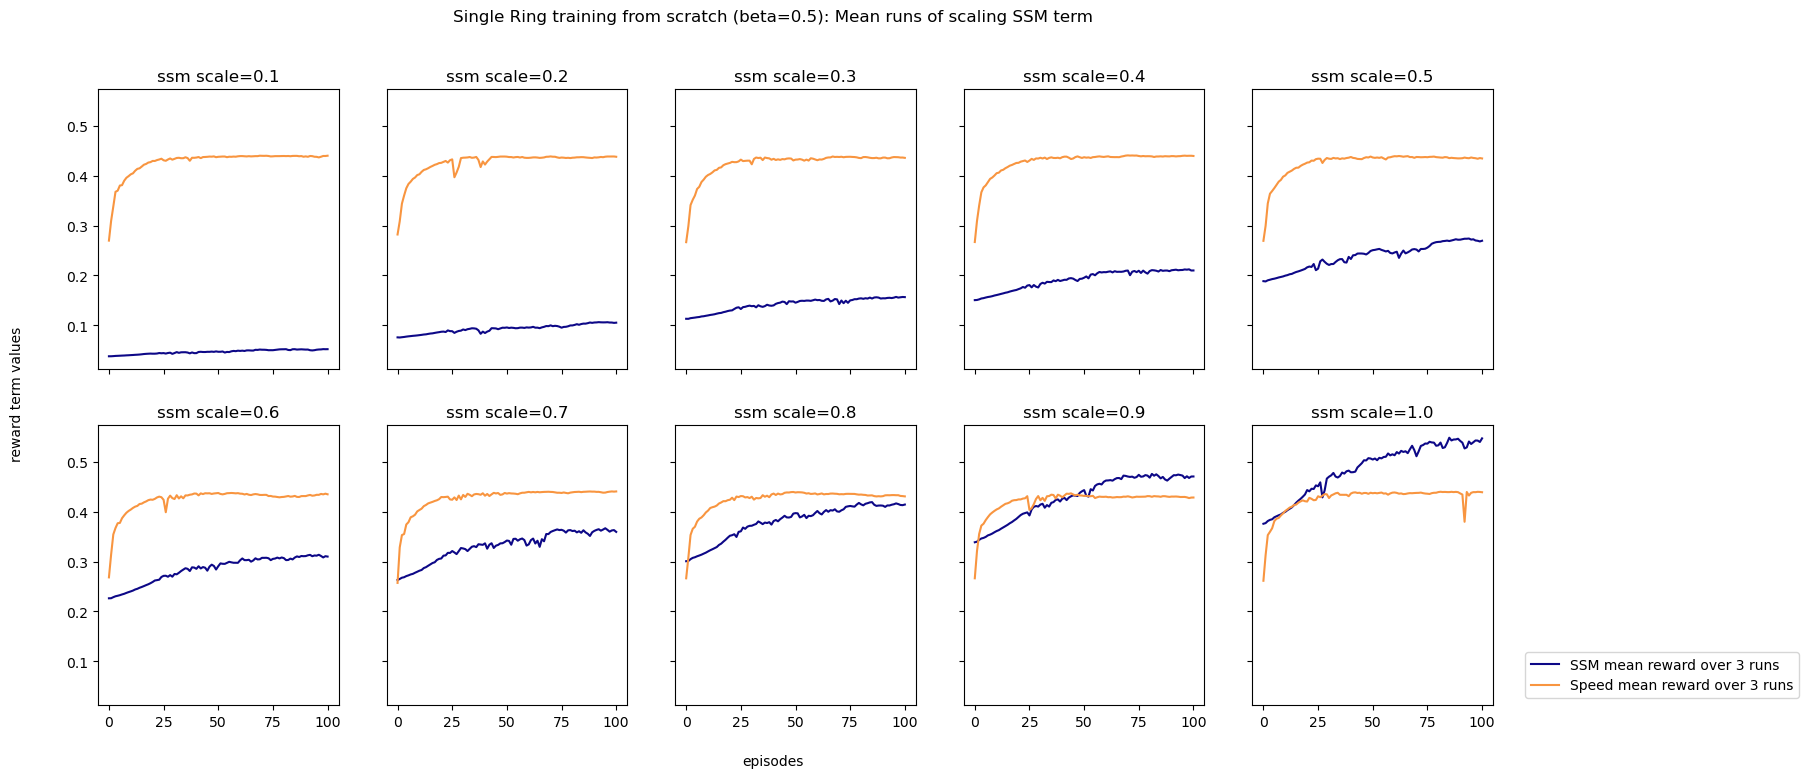

In [44]:
# train progress: plot mean reward terms of each ssm term scale value

# ssm_term = scale*(ttc - drac)/2
# reward_func = (0.5)*speed_reward + (0.5)*ssm_term

fig, axs = plt.subplots(2, 5, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (9 - 1)) for i in range(9)] # split plasma into 9 colors

for scale in scale_values:
    ssms, speeds = [], []
    for i in run_nums:
        
        cur_dir = f'{single_ring_scaling_SSM_dir}/beta0.5_SSM{scale}_run{i}'
        train_csv = f'{cur_dir}/train_results.csv'
        if os.path.exists(train_csv):
            train_df = pd.read_csv(train_csv)
            ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
            speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']

            ssms += [ssm_y]
            speeds += [speed_y]
            
    if ssms:
            
        max_length = max(len(x) for x in ssms)
        ssms = [np.pad(x, (0, max_length - len(x)), constant_values=np.nan) for x in ssms]
        ssms = np.vstack(ssms)
        ssm_mean = np.nanmean(ssms, axis=0)
        max_length = max(len(x) for x in speeds)
        speeds = [np.pad(x, (0, max_length - len(x)), constant_values=np.nan) for x in speeds]
        speeds = np.vstack(speeds)
        speed_mean = np.nanmean(speeds, axis=0)

        x = np.arange(max(len(ssm_mean), len(speed_mean)))

        ax = axs_flat[int(10*scale)-1]
        ax.set_title(f'ssm scale={scale}')
        ax.plot(x, ssm_mean, color=colors[0], label=f'SSM mean reward over 3 runs')
        ax.plot(x, speed_mean, color=colors[-3], label=f'Speed mean reward over 3 runs')

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Single Ring training from scratch (beta=0.5): Mean runs of scaling SSM term')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()



##### Pareto curve from scratch, all SSMs (TTC and DRAC)

In [37]:
single_scratch_exp_dir = f'{single_folder}/from_scratch'
Path(f'{single_scratch_exp_dir}').mkdir(parents=True, exist_ok=True)
beta_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)
seed_np = 1228644375
seed_torch = 106619
scale=0.8
n_steps=100

In [38]:
# train

# based on scaling section, reward func is as follows:
# ssm_term = 0.7*(ttc - drac)/2
# reward_func = (0.5)*speed_reward + (0.5)*ssm_term

def train_single_scratch(i_beta_pairs):
    output_logs = []
    for i, beta in i_beta_pairs:
        cur_dir = f'{single_scratch_exp_dir}/{beta}_{i}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train{beta}_{i}.log'
        train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, scale_ttc=scale, scale_drac=scale, n_steps=n_steps, seed_np=seed_np, seed_torch=seed_torch)
        train_script_path = f'{cur_dir}/train{beta}_{i}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
    return output_logs

In [39]:
train_outputs = train_single_scratch(product(run_nums, beta_values))
print(train_outputs)

['pareto/single_ring/from_scratch/0.0_0/train0.0_0.log', 'pareto/single_ring/from_scratch/0.0_1/train0.0_1.log', 'pareto/single_ring/from_scratch/0.0_2/train0.0_2.log', 'pareto/single_ring/from_scratch/0.1_0/train0.1_0.log', 'pareto/single_ring/from_scratch/0.1_1/train0.1_1.log', 'pareto/single_ring/from_scratch/0.1_2/train0.1_2.log', 'pareto/single_ring/from_scratch/0.2_0/train0.2_0.log', 'pareto/single_ring/from_scratch/0.2_1/train0.2_1.log', 'pareto/single_ring/from_scratch/0.2_2/train0.2_2.log', 'pareto/single_ring/from_scratch/0.3_0/train0.3_0.log', 'pareto/single_ring/from_scratch/0.3_1/train0.3_1.log', 'pareto/single_ring/from_scratch/0.3_2/train0.3_2.log', 'pareto/single_ring/from_scratch/0.4_0/train0.4_0.log', 'pareto/single_ring/from_scratch/0.4_1/train0.4_1.log', 'pareto/single_ring/from_scratch/0.4_2/train0.4_2.log', 'pareto/single_ring/from_scratch/0.5_0/train0.5_0.log', 'pareto/single_ring/from_scratch/0.5_1/train0.5_1.log', 'pareto/single_ring/from_scratch/0.5_2/train0.5

In [55]:
# retrain failed runs

# rm -rf relevant dir
train_single_scratch([(1.0, 2)])

['pareto/single_ring/from_scratch/1.0_2/train1.0_2.log']

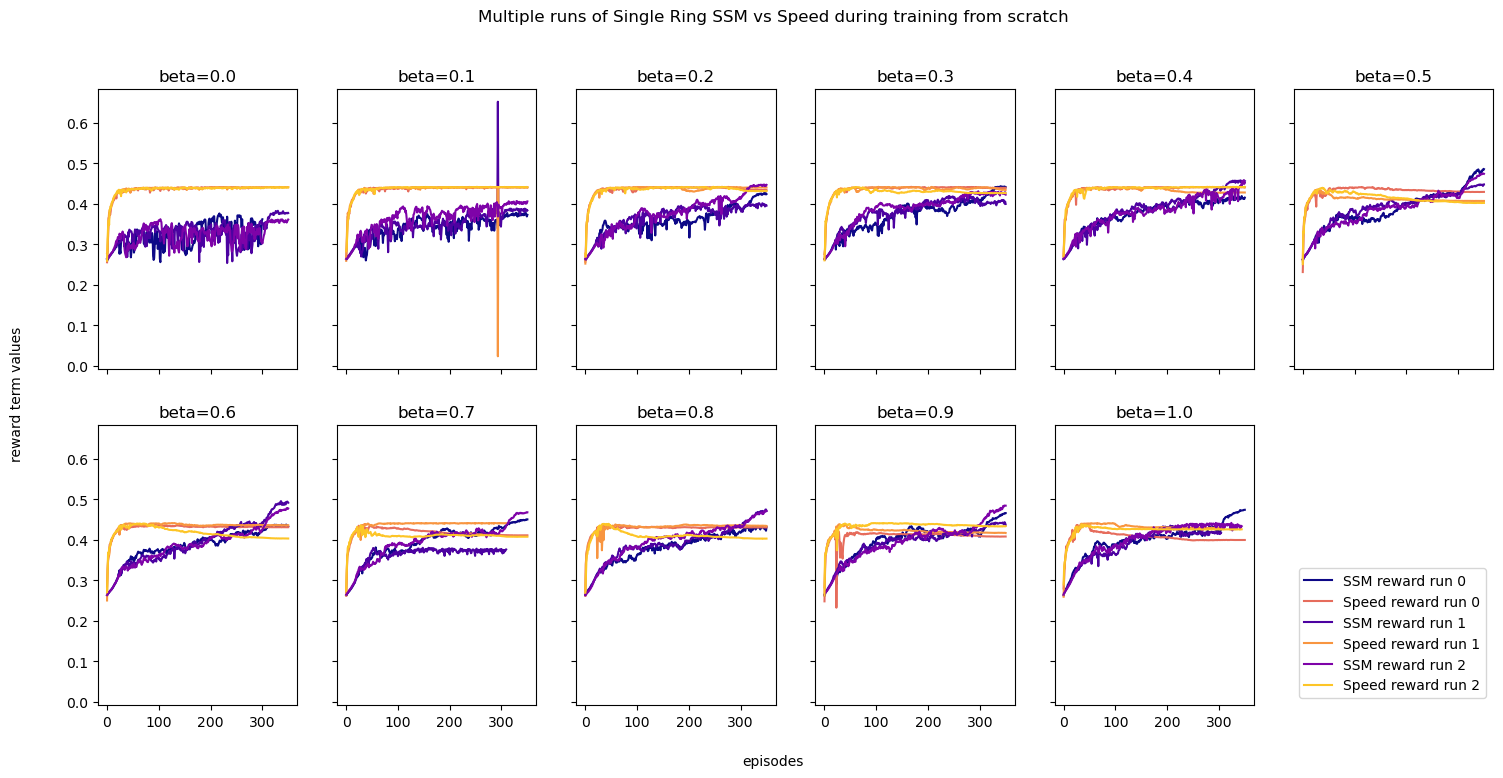

In [35]:
# train progress: plot training for each separate run, per beta

fig, axs = plt.subplots(2, 6, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (9 - 1)) for i in range(9)] # split plasma into 9 colors: [0, 1, 2] for 3 runs ssm, [5, 6, 7] for 3 runs speed

beta_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)
for i, beta in product(run_nums, beta_values):
    cur_dir = f'{single_scratch_exp_dir}/{beta}_{i}'
    train_csv = f'{cur_dir}/train_results.csv'
    if os.path.exists(train_csv):
        train_df = pd.read_csv(train_csv)
        ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
        speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
    
        x = np.arange(len(speed_y))
        
        ax = axs_flat[int(10*beta)]
        ax.set_title(f'beta={beta}')
        ax.plot(x, ssm_y, color=colors[i], label=f'SSM reward run {i}')
        ax.plot(x, speed_y, color=colors[5+i], label=f'Speed reward run {i}')
        
        # ttc_y, drac_y = train_df['ttc_mean'], train_df['drac_mean']
        # ax.plot(x, ttc_y, color='red', label=f'ttc run {i}')
        # ax.plot(x, -drac_y, color='green', label=f'-drac run {i}')

        
fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel
plt.suptitle('Multiple runs of Single Ring SSM vs Speed during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1, 0))
# plt.tight_layout()
plt.show()

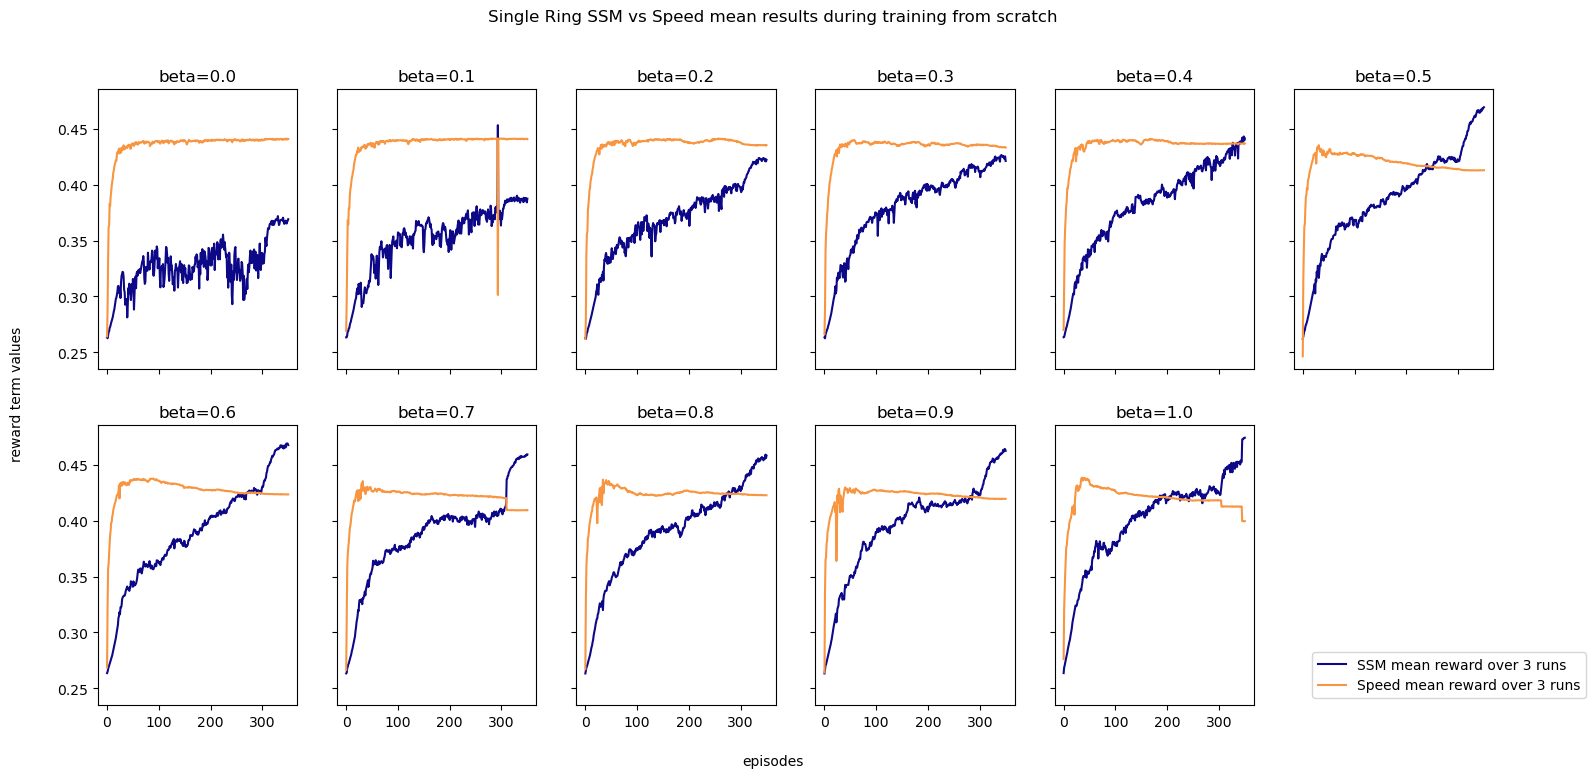

In [36]:
# train progress: plot mean training for each separate run, per beta

fig, axs = plt.subplots(2, 6, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (9 - 1)) for i in range(9)] # split plasma into 9 colors: [0, 1, 2] for 3 runs ssm, [5, 6, 7] for 3 runs speed

beta_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)
for beta in beta_values:
    ssms, speeds = [], []
    for i in run_nums:
        cur_dir = f'{single_scratch_exp_dir}/{beta}_{i}'
        train_csv = f'{cur_dir}/train_results.csv'
        if os.path.exists(train_csv):
            train_df = pd.read_csv(train_csv)
            ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
            speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
            
            ssms += [ssm_y]
            speeds += [speed_y]

    max_length = max(len(x) for x in ssms)
    ssms = [np.pad(x, (0, max_length - len(x)), constant_values=np.nan) for x in ssms]
    ssms = np.vstack(ssms)
    ssm_mean = np.nanmean(ssms, axis=0)
    max_length = max(len(x) for x in speeds)
    speeds = [np.pad(x, (0, max_length - len(x)), constant_values=np.nan) for x in speeds]
    speeds = np.vstack(speeds)
    speed_mean = np.nanmean(speeds, axis=0)
    
    x = np.arange(max(len(ssm_mean), len(speed_mean)))

    ax = axs_flat[int(10*beta)]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ssm_mean, color=colors[0], label=f'SSM mean reward over 3 runs')
    ax.plot(x, speed_mean, color=colors[-3], label=f'Speed mean reward over 3 runs')

        
fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel
plt.suptitle('Single Ring SSM vs Speed mean results during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.5, 0))
# plt.tight_layout()
plt.show()

In [20]:
# verify successful train
train_outputs=['pareto/single_ring/from_scratch/0.0_0/train0.0_0.log', 'pareto/single_ring/from_scratch/0.0_1/train0.0_1.log', 'pareto/single_ring/from_scratch/0.0_2/train0.0_2.log', 'pareto/single_ring/from_scratch/0.1_0/train0.1_0.log', 'pareto/single_ring/from_scratch/0.1_1/train0.1_1.log', 'pareto/single_ring/from_scratch/0.1_2/train0.1_2.log', 'pareto/single_ring/from_scratch/0.2_0/train0.2_0.log', 'pareto/single_ring/from_scratch/0.2_1/train0.2_1.log', 'pareto/single_ring/from_scratch/0.2_2/train0.2_2.log', 'pareto/single_ring/from_scratch/0.3_0/train0.3_0.log', 'pareto/single_ring/from_scratch/0.3_1/train0.3_1.log', 'pareto/single_ring/from_scratch/0.3_2/train0.3_2.log', 'pareto/single_ring/from_scratch/0.4_0/train0.4_0.log', 'pareto/single_ring/from_scratch/0.4_1/train0.4_1.log', 'pareto/single_ring/from_scratch/0.4_2/train0.4_2.log', 'pareto/single_ring/from_scratch/0.5_0/train0.5_0.log', 'pareto/single_ring/from_scratch/0.5_1/train0.5_1.log', 'pareto/single_ring/from_scratch/0.5_2/train0.5_2.log', 'pareto/single_ring/from_scratch/0.6_0/train0.6_0.log', 'pareto/single_ring/from_scratch/0.6_1/train0.6_1.log', 'pareto/single_ring/from_scratch/0.6_2/train0.6_2.log', 'pareto/single_ring/from_scratch/0.7_0/train0.7_0.log', 'pareto/single_ring/from_scratch/0.7_1/train0.7_1.log', 'pareto/single_ring/from_scratch/0.7_2/train0.7_2.log', 'pareto/single_ring/from_scratch/0.8_0/train0.8_0.log', 'pareto/single_ring/from_scratch/0.8_1/train0.8_1.log', 'pareto/single_ring/from_scratch/0.8_2/train0.8_2.log', 'pareto/single_ring/from_scratch/0.9_0/train0.9_0.log', 'pareto/single_ring/from_scratch/0.9_1/train0.9_1.log', 'pareto/single_ring/from_scratch/0.9_2/train0.9_2.log', 'pareto/single_ring/from_scratch/1.0_0/train1.0_0.log', 'pareto/single_ring/from_scratch/1.0_1/train1.0_1.log', 'pareto/single_ring/from_scratch/1.0_2/train1.0_2.log']
verify_multiple_execution(train_outputs) 

failed scripts: ['pareto/single_ring/from_scratch/0.7_1/train0.7_1.log', 'pareto/single_ring/from_scratch/1.0_1/train1.0_1.log']


In [40]:
# eval

def eval_single_scratch(beta_i_pairs):
    output_logs = []
    for beta, i in beta_i_pairs:
        cur_dir = f'{single_scratch_exp_dir}/{beta}_{i}'
        output_log_name = f'{cur_dir}/eval{beta}_{i}.log'
        eval_script_text = single_ring_eval_script_text(e='85', output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
        eval_script_path = f'{cur_dir}/eval{beta}_{i}.sh'
        create_file_with_contents(eval_script_path, eval_script_text)
        out, err = submit_job(eval_script_path)
        output_logs += [output_log_name]
    return output_logs

In [41]:
eval_outputs = eval_single_scratch(product(beta_values,run_nums))
print(eval_outputs)

['pareto/single_ring/from_scratch/0.0_0/eval0.0_0.log', 'pareto/single_ring/from_scratch/0.0_1/eval0.0_1.log', 'pareto/single_ring/from_scratch/0.0_2/eval0.0_2.log', 'pareto/single_ring/from_scratch/0.1_0/eval0.1_0.log', 'pareto/single_ring/from_scratch/0.1_1/eval0.1_1.log', 'pareto/single_ring/from_scratch/0.1_2/eval0.1_2.log', 'pareto/single_ring/from_scratch/0.2_0/eval0.2_0.log', 'pareto/single_ring/from_scratch/0.2_1/eval0.2_1.log', 'pareto/single_ring/from_scratch/0.2_2/eval0.2_2.log', 'pareto/single_ring/from_scratch/0.3_0/eval0.3_0.log', 'pareto/single_ring/from_scratch/0.3_1/eval0.3_1.log', 'pareto/single_ring/from_scratch/0.3_2/eval0.3_2.log', 'pareto/single_ring/from_scratch/0.4_0/eval0.4_0.log', 'pareto/single_ring/from_scratch/0.4_1/eval0.4_1.log', 'pareto/single_ring/from_scratch/0.4_2/eval0.4_2.log', 'pareto/single_ring/from_scratch/0.5_0/eval0.5_0.log', 'pareto/single_ring/from_scratch/0.5_1/eval0.5_1.log', 'pareto/single_ring/from_scratch/0.5_2/eval0.5_2.log', 'pareto/s

In [ ]:
# rerun failed evals ():

# rm -rf relevant files
eval_single_scratch([(beta, i)])

In [23]:
# verify successful eval
verify_multiple_execution(eval_outputs)

all scripts success!


[0.46380534578601385, 0.48008836100665603, 0.4968418321429698, 0.5121578834519773, 0.5046659860677954, 0.5140334968899869, 0.5042161371856738, 0.48104058060413557, 0.5260958335348559, 0.5302145950357833, 0.5134262673948561] [0.43585163724568615, 0.43904622092474505, 0.4394078796798786, 0.4370847027853655, 0.43750267107422425, 0.4285560978308145, 0.43721294738295075, 0.37040754994454733, 0.4266062796234857, 0.4255010659281006, 0.42920314483179567]


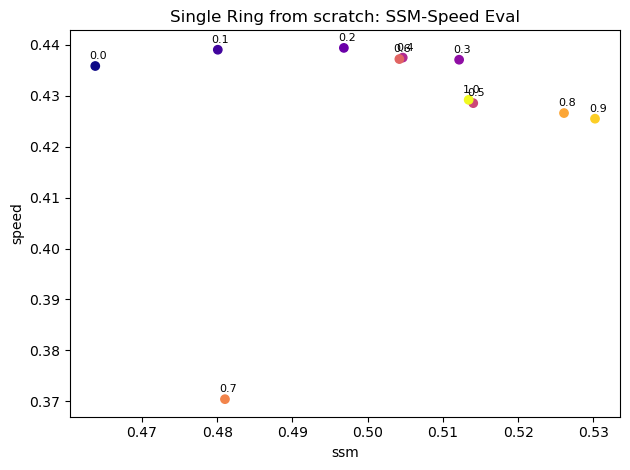

In [32]:
# plot all eval points

ssms, speeds = [], []

beta_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)
for beta in beta_values:
    cur_ssms, cur_speeds = [], []
    for i in run_nums:
        cur_dir = f'{single_scratch_exp_dir}/{beta}_{i}'
        eval_df = pd.read_csv(f'{cur_dir}/eval.csv')
        
        cur_ssms += [np.mean(eval_df['ssm_mean'])]
        cur_speeds += [np.mean(eval_df['speed_reward_mean'])]
        
    # print('cur_ssms', np.mean(cur_ssms))
    # print('cu_speeds', np.mean(cur_speeds))
    
    ssms += [np.mean(cur_ssms)]
    speeds += [np.mean(cur_speeds)]
    
print(ssms, speeds)

plt.scatter(ssms, speeds, c=np.arange(11), cmap='plasma')
for i, (xi, yi) in enumerate(zip(ssms, speeds)):
    plt.annotate(f'{i/10}', (xi, yi), textcoords="offset points", xytext=(2,5),
                 ha='center', fontsize=8)

plt.title('Single Ring from scratch: SSM-Speed Eval')
plt.xlabel('ssm')
plt.ylabel('speed')
plt.tight_layout()
plt.show()

In [ ]:
# plot Pareto frontier of evals



##### Pareto curve from finetuning

In [ ]:
finetune_single_exp_dir = f'{single_folder}/finetune'
Path(f'{finetune_single_exp_dir}').mkdir(parents=True, exist_ok=True)
beta_values=[b/10.0 for b in range(11)]
run_nums=np.arange(single_num_runs)

In [ ]:
# train

output_logs = []

for source in range(11):
    for target in range(11):
        s, t = source/10, target/10
        # make new directory structure for each source in the finetune exp dir
        # copy over source model checkpoints
        # copy over source train_results.csv up to source_e
        # how to determine how many more episodes to finetune for?
        # need to also have code for finetuning plots
        # submit train scripts 
        # output logs blah blah
        
        
        cur_dir = f'{finetune_single_exp_dir}/{beta}'
        Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
        output_log_name = f'{cur_dir}/train{beta}.log'
        train_script_text = double_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
        train_script_path = f'{cur_dir}/train{beta}.sh'
        create_file_with_contents(train_script_path, train_script_text)
        out, err = submit_job(train_script_path)
        output_logs += [output_log_name]
print(output_logs)

# eval:

# for each source
# for each target
# submit eval script

# pick best 

In [79]:
# experiments/plots:
# training ttc vs speed plots of different beta vals
# naive pareto curve of different beta vals
# finetuning pareto curve of best target for each source beta val



other methods ("best" means highest average eval reward):
- finetuning (for each target, take the best policy from {Source scratch} x {Target finetune}. Pareto frontier is frontier of these points)
- best-of finetuning (for each target, take the best policy from {Best Source methods} x {Target finetune})
- sidetuning
- 

##### Pareto curve from residual transfer

In [ ]:
residual_transfer_single_exp_dir = f'{single_folder}/residual_transfer'
Path(f'{residual_transfer_single_exp_dir}').mkdir(parents=True, exist_ok=True)

In [4]:
reward_scaling_grid_search_exp_dir = f'{folder}/scaling_grid_search'
Path(f'{reward_scaling_grid_search_exp_dir}').mkdir(parents=True, exist_ok=True)

In [18]:
 # for scale_ttc in range(3):
 #    for scale_pet in range(3):
 #        for scale_drac in range(3):
scale_ttc, scale_pet, scale_drac = 0, 2, 2
n_steps=50*(1+scale_ttc+scale_drac+scale_pet)

b=5
beta = b/10
exp_name=f'beta{beta}_ttc{scale_ttc}_pet{scale_pet}_drac{scale_drac}_episodes{n_steps}'

cur_dir = f'{reward_scaling_grid_search_exp_dir}/{exp_name}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train_{exp_name}.log'
train_script_text = single_ring_train_script_text(
    output_log=output_log_name, 
    run_dir=cur_dir, 
    beta=beta, 
    scale_ttc=scale_ttc,
    scale_pet=scale_pet,
    scale_drac=scale_drac,
    n_steps=n_steps,
)
train_script_path = f'{cur_dir}/train_{exp_name}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)

File 'pareto/single_ring/scaling_grid_search/beta0.5_ttc0_pet2_drac2_episodes250/train_beta0.5_ttc0_pet2_drac2_episodes250.sh' created successfully with contents.


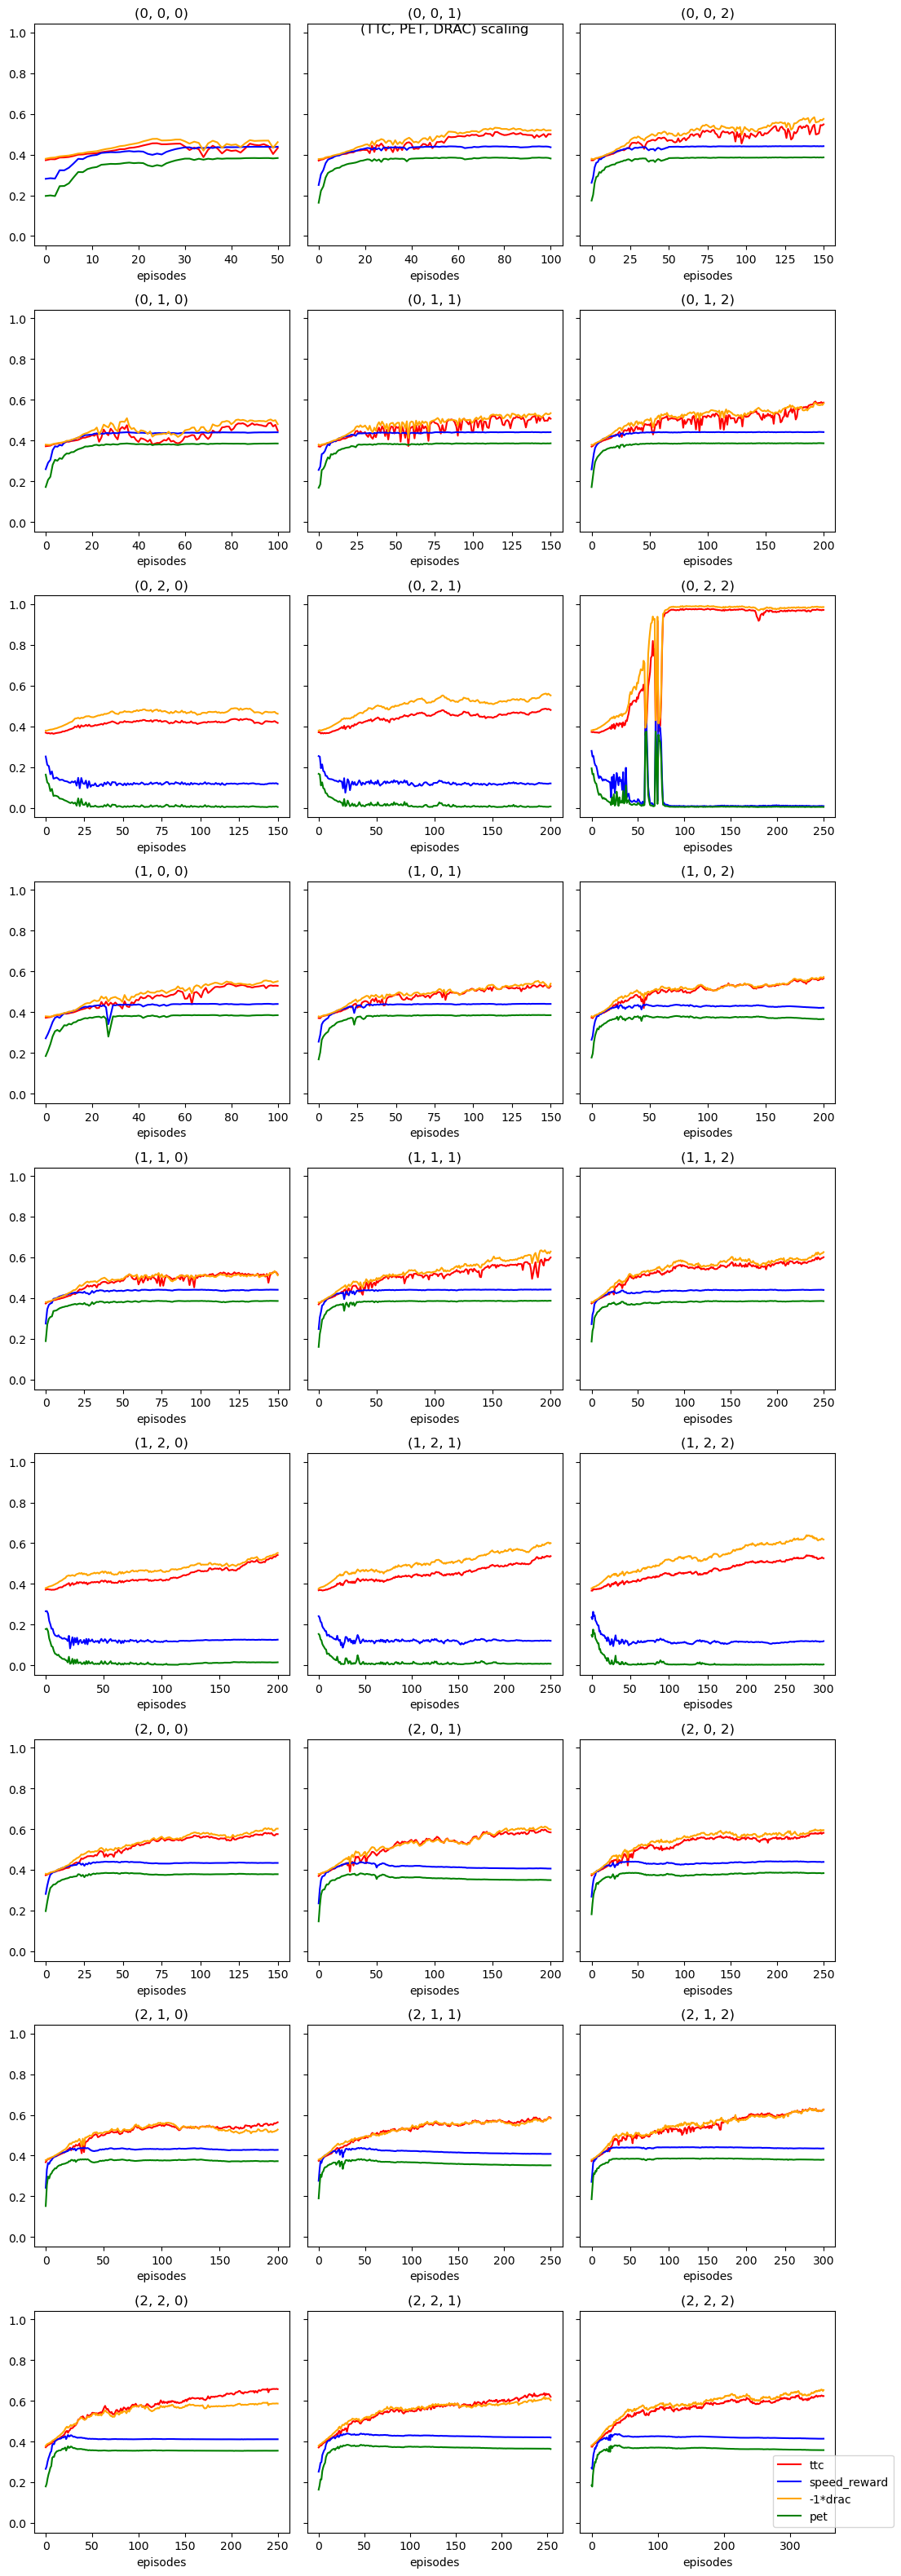

In [10]:
# graphing 3 x 3 x 3

fig, axs = plt.subplots(9, 3, figsize=(11, 32),  sharey=True)
axs_flat = axs.flatten()

for scale_ttc in range(3):
    for scale_pet in range(3):
        for scale_drac in range(3):
            n_steps=50*(1+scale_ttc+scale_drac+scale_pet)
            b=5
            beta = b/10

            exp_name=f'beta{beta}_ttc{scale_ttc}_pet{scale_pet}_drac{scale_drac}_episodes{n_steps}'
            cur_dir = f'{reward_scaling_grid_search_exp_dir}/{exp_name}'
            train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

            ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
            speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
            drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
            pet_y, pet_std = -np.log10(train_df['pet_mean']), train_df['pet_std']

            # print(train_df['pet_mean'], train_df['pet_std'])

            x = np.arange(len(speed_y))
    
            ax = axs_flat[9*scale_ttc + 3*scale_pet + 1*scale_drac]
            ax.set_title(f'({scale_ttc}, {scale_pet}, {scale_drac})')
            ax.plot(x, ttc_y, color='red', label='ttc')
            # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
            ax.plot(x, speed_y, color='blue', label='speed_reward')
            # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_reward ± 1 std')

            ax.plot(x, drac_y, color='orange', label='-1*drac')
            # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='orange', alpha=0.2, label='-1*drac ± 1 std')
            ax.plot(x, pet_y, color='green', label='pet')
            # ax.fill_between(x, pet_y-pet_std, pet_y+pet_std, color='green', alpha=0.2, label='pet ± 1 std')

            ax.set_xlabel('episodes')

plt.suptitle('(TTC, PET, DRAC) scaling')
# axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [12]:
testing_all_ssms_exp_dir = f'{folder}/testing_all_ssms'
Path(f'{testing_all_ssms_exp_dir}').mkdir(parents=True, exist_ok=True)

In [53]:
b=5
beta = b/10
cur_dir = f'{testing_all_ssms_exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, n_steps=400)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)

File 'pareto/single_ring/testing_all_ssms/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25521251
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


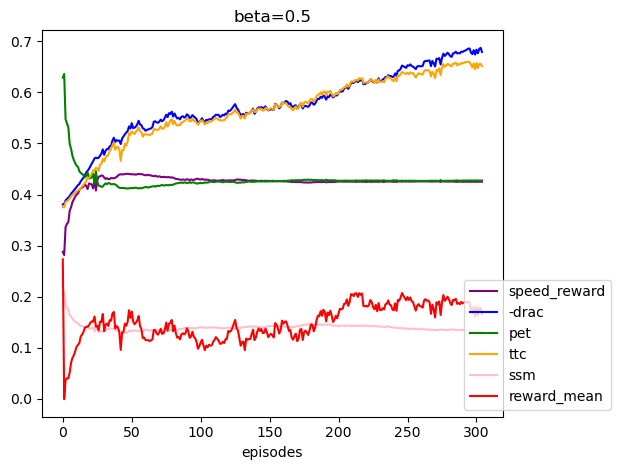

In [13]:
# plot training ttc vs speed for 0.5, see if ttc will converge

# x = np.arange(51)

b=5
beta = b/10
cur_dir = f'{testing_all_ssms_exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
pet_y, pet_std = train_df['pet_mean'], train_df['pet_std']

reward_y = 100*train_df['reward_mean']

# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

# speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
ssm_y = (ttc_y+pet_y-drac_y)/3
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
# reward_y = train_df['reward_mean']

x = np.arange(len(speed_reward_y))


plt.title(f'beta={beta}')
# plt.plot(x, ttc_y, color='red', label='ttc')
# plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
# plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')

plt.plot(x, drac_y, color='blue', label='-drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='blue', alpha=0.2, label='drac ± 1 std')
plt.plot(x, pet_y, color='green', label='pet')
# plt.fill_between(x, pet_y-pet_std, pet_y+pet_std, color='green', alpha=0.2, label='pet ± 1 std')

plt.plot(x, ttc_y, color='orange', label='ttc')
# plt.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='orange', alpha=0.2, label='ssm ± 1 std')

plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.plot(x, reward_y, color='red', label='reward_mean')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [48]:
exp_dir = f'{folder}/testing'
Path(f'{exp_dir}').mkdir(parents=True, exist_ok=True)

In [4]:

b=5
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, n_steps=1000)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)

File 'pareto/single_ring/testing/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25483459
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


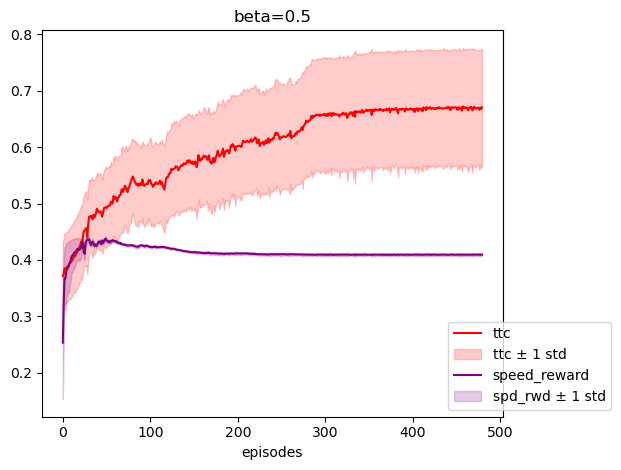

In [51]:
# plot training ttc vs speed for 0.5, see if ttc will converge

# x = np.arange(51)

b=5
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']

# speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
# drac_y, drac_std = train_df['drac_mean'], train_df['drac_std']
# ssm_y = ttc_y-drac_y
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
# reward_y = train_df['reward_mean']

x = np.arange(len(speed_reward_y))


plt.title(f'beta={beta}')
plt.plot(x, ttc_y, color='red', label='ttc')
plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')

# plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.plot(x, drac_y, color='green', label='drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [30]:
three_ssms_exp_dir = f'{folder}/testing_three_ssms'
Path(f'{three_ssms_exp_dir}').mkdir(parents=True, exist_ok=True)

output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{three_ssms_exp_dir}/{beta}'
    Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
    output_log_name = f'{cur_dir}/train{beta}.log'
    train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
    train_script_path = f'{cur_dir}/train{beta}.sh'
    create_file_with_contents(train_script_path, train_script_text)
    out, err = submit_job(train_script_path)
    print(out, err)
    output_logs += [output_log_name]

File 'pareto/single_ring/testing_three_ssms/0.0/train0.0.sh' created successfully with contents.
Submitted batch job 25485006
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.1/train0.1.sh' created successfully with contents.
Submitted batch job 25485007
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.2/train0.2.sh' created successfully with contents.
Submitted batch job 25485008
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.3/train0.3.sh' created successfully with contents.
Submitted batch job 25485009
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.4/train0.4.sh' created successfully with contents.
Submitted batch job 25485010
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25485011
LLGrid: TXE1 (running slurm-w

In [ ]:
# verify successful train
verify_multiple_execution(output_logs) 

NameError: name 'three_ssms_exp_dir' is not defined

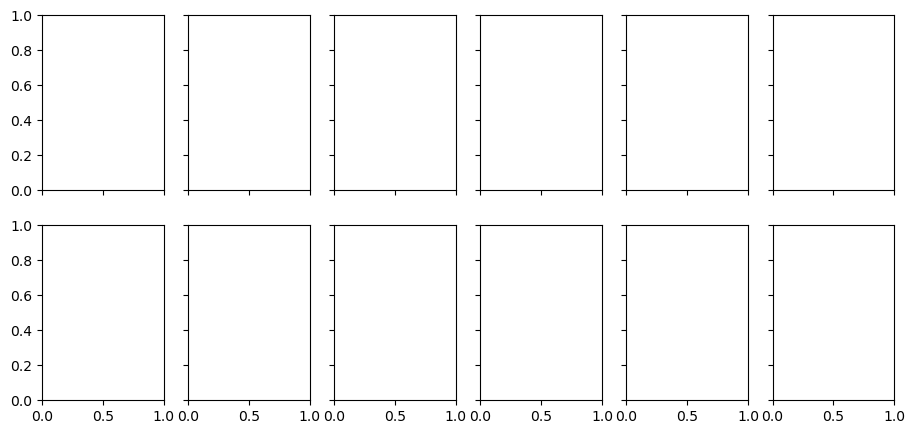

In [17]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(11, 5), sharex=True, sharey=True)
axs_flat = axs.flatten()


for b in range(1,11):
    beta = b/10
    cur_dir = f'{three_ssms_exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')
    
    ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
    speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
    drac_y, drac_std = 900*train_df['drac_mean'], train_df['drac_std']
    pet_y, pet_std = -np.log10(train_df['pet_mean'])/16, train_df['pet_std']
    
    # print(train_df['pet_mean'], train_df['pet_std'])
    
    x = np.arange(len(speed_y))
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ttc_y, color='red', label='ttc')
    ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
    ax.plot(x, speed_y, color='blue', label='speed_reward')
    ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_reward ± 1 std')
    
    ax.plot(x, drac_y, color='pink', label='drac')
    ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='pink', alpha=0.2, label='drac ± 1 std')
    ax.plot(x, pet_y, color='green', label='pet')
    ax.fill_between(x, pet_y-pet_std, pet_y+pet_std, color='green', alpha=0.2, label='pet ± 1 std')
    
    ax.set_xlabel('episodes')

plt.suptitle('Single Ring TTC and speed_RL during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

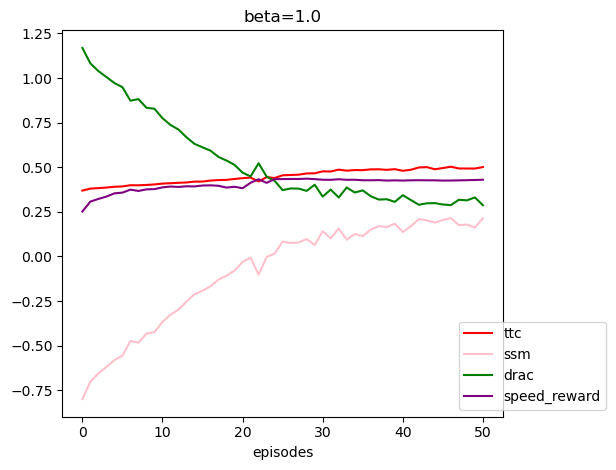

In [75]:
# plot training ttc/drac vs speed for each beta

# x = np.arange(51)

b=10
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']

drac_y, drac_std = 3*train_df['drac_mean'], train_df['drac_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
ssm_y = ttc_y-drac_y
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
reward_y = 100*train_df['reward_mean']

x = np.arange(len(speed_y))


plt.title(f'beta={beta}')
plt.plot(x, ttc_y, color='red', label='ttc')
# plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
# plt.plot(x, speed_y, color='blue', label='speed_rl')
# plt.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_rl ± 1 std')
plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='pink', alpha=0.2, label='ssm ± 1 std')

plt.plot(x, drac_y, color='green', label='drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
# plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [13]:
# train

output_logs = []

b=5
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
output_logs += [output_log_name]
print(output_logs)

File 'pareto/single_ring/from_scratch_ttc_drac/0.0/train0.0.sh' created successfully with contents.
Submitted batch job 25420822
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.1/train0.1.sh' created successfully with contents.
Submitted batch job 25420823
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.2/train0.2.sh' created successfully with contents.
Submitted batch job 25420824
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.3/train0.3.sh' created successfully with contents.
Submitted batch job 25420825
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.4/train0.4.sh' created successfully with contents.
Submitted batch job 25420826
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25420827
LLGrid: TXE

In [48]:
# verify successful train
verify_multiple_execution(output_logs) 
    
# eval
output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    output_log_name = f'{cur_dir}/eval{beta}.log'
    eval_script_text = single_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
    eval_script_path = f'{cur_dir}/eval{beta}.sh'
    create_file_with_contents(eval_script_path, eval_script_text)
    out, err = submit_job(eval_script_path)
    print(out, err)
    output_logs += [output_log_name]

all scripts success!
File 'pareto/single_ring/from_scratch_ttc_drac/0.0/eval0.0.sh' created successfully with contents.
Submitted batch job 25412657
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.1/eval0.1.sh' created successfully with contents.
Submitted batch job 25412658
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.2/eval0.2.sh' created successfully with contents.
Submitted batch job 25412659
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.3/eval0.3.sh' created successfully with contents.
Submitted batch job 25412660
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.4/eval0.4.sh' created successfully with contents.
Submitted batch job 25412661
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.5/eval0.5.sh' created successfully with contents.
Submitted batch job 25412

In [ ]:
# verify successful eval
verify_multiple_execution(output_logs)

FileNotFoundError: [Errno 2] No such file or directory: 'pareto/single_ring/from_scratch_ttc_drac_ssm_scaling/0.1/train_results.csv'

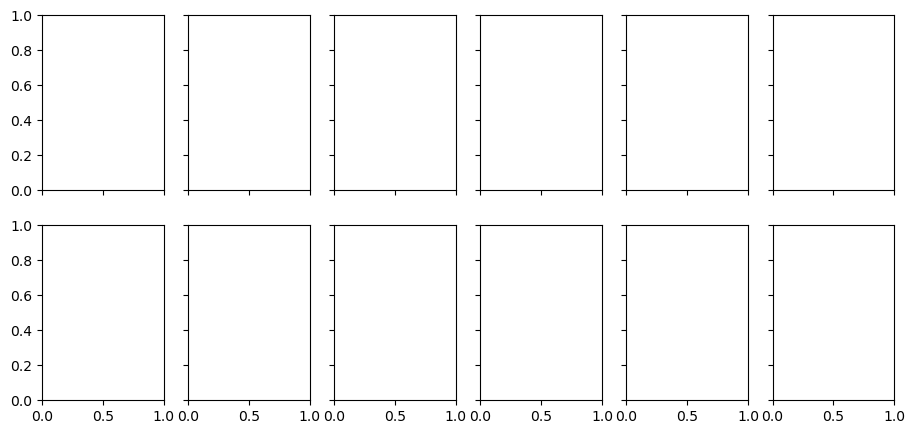

In [32]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(11, 5), sharex=True, sharey=True)
axs_flat = axs.flatten()
x = np.arange(51)

for b in range(1, 11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')
    
    ttc_y, ttc_std = train_df['ttc_mean']/7, train_df['ttc_std']/7
    speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
    
    drac_y, drac_std = train_df['drac_mean']*1500, train_df['drac_std']*50
    speed_reward_y, speed_reward_std = train_df['speed_reward_mean']/10, train_df['speed_reward_std']/10
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ttc_y, color='red', label='ttc')
    ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
    # ax.plot(x, speed_y, color='blue', label='speed_rl')
    # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_rl ± 1 std')
    
    # ax.plot(x, drac_y, color='green', label='drac')
    # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
    ax.plot(x, speed_reward_y, color='purple', label='speed_reward')
    ax.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')
    
    
    ax.set_xlabel('episodes')

plt.suptitle('Single Ring TTC, DRAC, speed_RL during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [ ]:
# plot pareto curve

ttcs = []
speeds = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    eval_df = pd.read_csv(f'{cur_dir}/eval.csv')
    
    ttcs += [np.mean(eval_df['ttc_mean'])/7]
    speeds += [np.mean(eval_df['speed_rl'])/10]
    
plt.scatter(ttcs, speeds, c=np.arange(11), cmap='plasma')

for i, (xi, yi) in enumerate(zip(ttcs, speeds)):
    plt.annotate(f'{i/10}', (xi, yi), textcoords="offset points", xytext=(2,5),
                 ha='center', fontsize=8)

plt.title('Single Ring training from scratch: TTC-Speed Pareto')
plt.tight_layout()
plt.show()

## double ring

#### helper funcs

In [12]:
double_folder = 'pareto/double_ring'
double_scratch_num_runs = 3 #number of training runs for each experiment

def double_ring_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        n_lanes=2,
        n_steps=100,
        worker_kwargs=[{'circumference':250}], 
        n_workers=40,
        n_rollouts_per_step=40, 
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=5000,
        global_reward=True,
        # n_steps=100, # default 100
        alg='TRPO',
        use_critic=False,
        gamma=0.999,
        beta=0,
        scale_ttc=1,
        scale_pet=1,
        scale_drac=1,
        seed_np=False,
        seed_torch=False,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "n_lanes={n_lanes}" "worker_kwargs={worker_kwargs}" "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "warmup_steps={warmup_steps}"'''
f''' "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "global_reward={global_reward}" "alg='{alg}'" "use_critic={use_critic}" "gamma={gamma}" "beta={beta}"'''
f''' "n_steps={n_steps}" "scale_ttc={scale_ttc}" "scale_pet={scale_pet}" "scale_drac={scale_drac}" "seed_np={seed_np}" "seed_torch={seed_torch}"'''
                  )
    return script_text

def double_ring_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        e='100',
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=1000,
        circumference=250,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "e={e}" "circumference={circumference}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}"'''
                  )
    return script_text


##### find seed


In [14]:
import random
double_ring_seed_dir = f'{double_folder}/seeding'
Path(f'{double_ring_seed_dir}').mkdir(parents=True, exist_ok=True)

def seed_double(torch_seeds, np_seeds, num_runs=1):
    output_logs = []
    for i in range(8):
        for r in range(num_runs):
            torch_seed, np_seed = torch_seeds[i], np_seeds[i]
            cur_dir = f'{single_ring_seed_dir}/beta0.5_SSM1_torch{torch_seed}_np{np_seed}_{r}'
            Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
            output_log_name = f'{cur_dir}/train.log'
            train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=0.5, n_steps=175, seed_torch=torch_seed, seed_np=np_seed)
            train_script_path = f'{cur_dir}/traintorch{torch_seed}_np{np_seed}_{r}_beta0.5_SSM1.sh'
            create_file_with_contents(train_script_path, train_script_text)
            out, err = submit_job(train_script_path)
            output_logs += [output_log_name]
    return output_logs

In [15]:
random_torch_seeds = [random.randint(0, 1000000) for _ in range(8)]

seed_seq = np.random.SeedSequence()
random_np_seeds = seed_seq.generate_state(8)

print(random_torch_seeds)
print(random_np_seeds)

outputs = seed_double(random_torch_seeds, random_np_seeds, 2)
print(outputs)

[294334, 789334, 2230, 719900, 163294, 472352, 768924, 78194]
[3695343398 3809329783 1406418984  932307645 1823195711 3440784316
  410281240 4140499927]
['pareto/single_ring/seeding/beta0.5_SSM1_torch294334_np3695343398_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch294334_np3695343398_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch789334_np3809329783_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch789334_np3809329783_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch2230_np1406418984_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch2230_np1406418984_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch719900_np932307645_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch719900_np932307645_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch163294_np1823195711_0/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch163294_np1823195711_1/train.log', 'pareto/single_ring/seeding/beta0.5_SSM1_torch472352

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


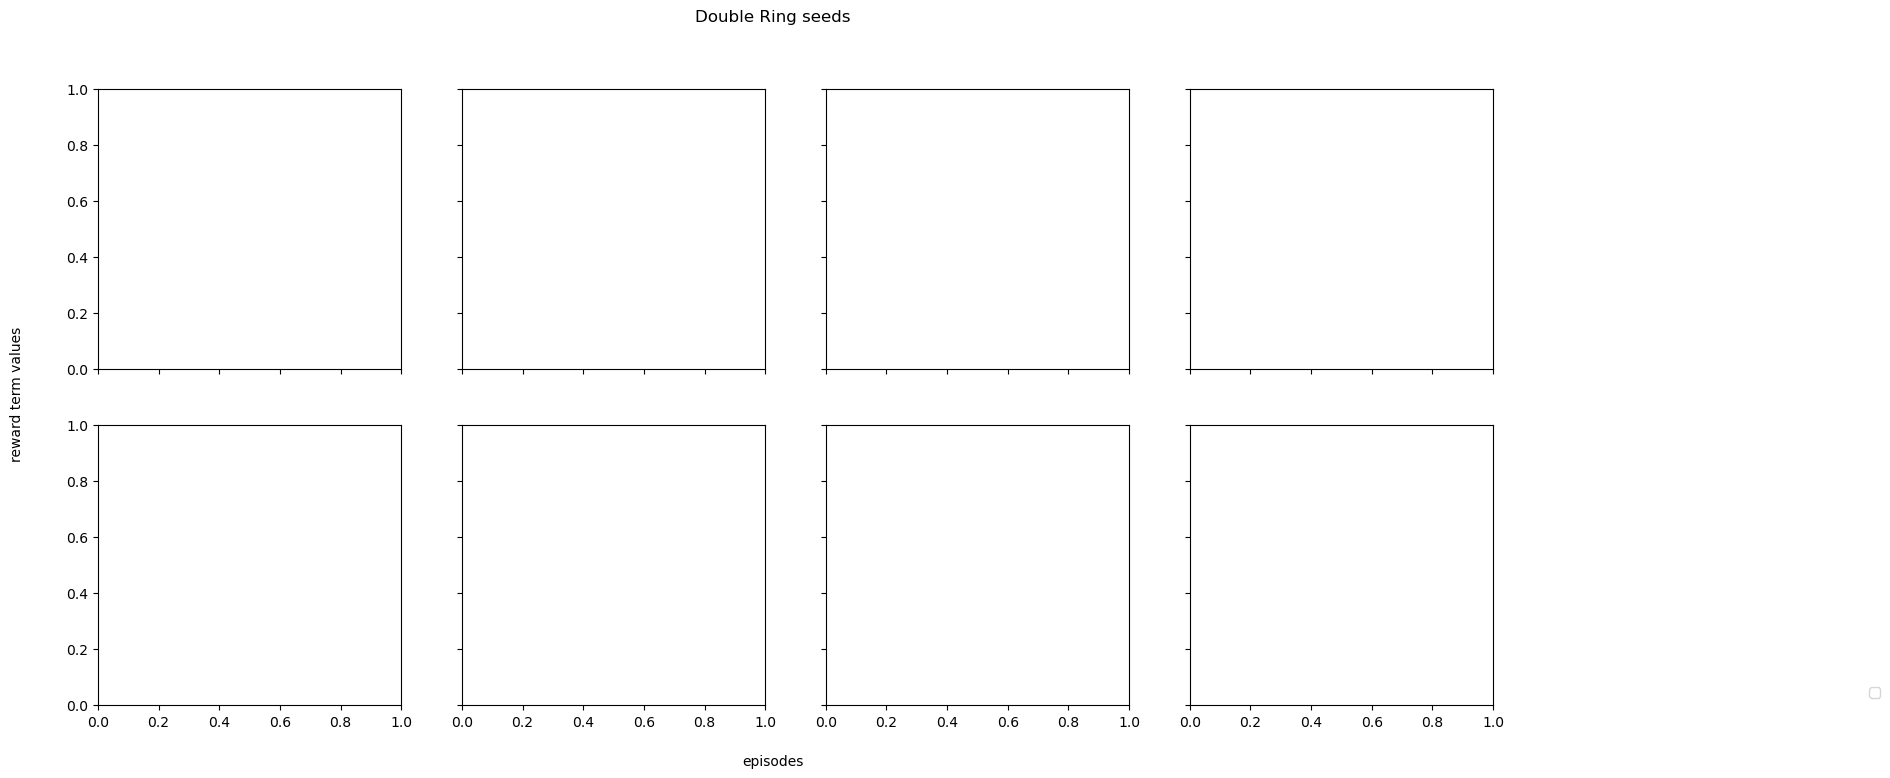

In [16]:
# train progress: plot rewards for each seed

fig, axs = plt.subplots(2, 4, figsize=(18, 8),  sharex=True, sharey=True)
axs_flat = axs.flatten()

cmap_plasma = plt.cm.get_cmap('plasma')
colors = [cmap_plasma(i / (5 - 1)) for i in range(5)] # split plasma into 12 colors

random_torch_seeds = [294334, 789334, 2230, 719900, 163294, 472352, 768924, 78194]
random_np_seeds = [3695343398, 3809329783, 1406418984,  932307645, 1823195711, 3440784316, 410281240, 4140499927]


for i in range(8):
    for r in range(2):
        torch_seed, np_seed = random_torch_seeds[i], random_np_seeds[i]
        cur_dir = f'{double_ring_seed_dir}/beta0.5_SSM1_torch{torch_seed}_np{np_seed}_{r}'
        train_csv = f'{cur_dir}/train_results.csv'
        if os.path.exists(train_csv):
            try:
                train_df = pd.read_csv(train_csv)
                ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
                speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
                drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
                ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

                x = np.arange(len(speed_y))

                # pet_y = train_df['pet_mean']
                # ax.plot(x, pet_y, color='orange', label='pet')

                ax = axs_flat[i]
                ax.set_title(f'torch seed {torch_seed}, np seed {np_seed}')
                # ax.plot(x, ttc_y, color=colors[0], label=f'TTC run{i}')
                # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2)
                # ax.plot(x, drac_y, color=colors[1], label=f'-1 * DRAC run{i}')
                # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='purple', alpha=0.2)
                ax.plot(x, ssm_y, color=colors[2], label=f'SSM reward +/- 1 STD')
                # ax.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='red', alpha=0.2)
                ax.plot(x, speed_y, color=colors[3], label=f'Speed reward +/- 1 STD')
                # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2)
            except:
                 print(torch_seed, np_seed, r, 'failed')

fig.text(0.5, 0.04, 'episodes', ha='center', va='center') # xlabel
fig.text(0.08, 0.5, 'reward term values', ha='center', va='center', rotation='vertical') # ylabel

plt.suptitle('Double Ring seeds')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(2.3, 0))
# plt.tight_layout()
plt.show()

##### Scaling SSM reward term (from scratch, TTC & DRAC)

In [ ]:
double_ring_scaling_SSM_dir = f'{double_folder}/ssm_scaling'
Path(f'{double_ring_scaling_SSM_dir}').mkdir(parents=True, exist_ok=True)

scale_values=[s/10.0 for s in range(1, 11)]
run_nums=np.arange(double_num_runs)

seed_np = False
seed_torch = 503020

##### Pareto curve from scratch

In [5]:
double_scratch_exp_dir = f'{double_folder}/from_scratch_ttc'
Path(f'{double_scratch_exp_dir}').mkdir(parents=True, exist_ok=True)

beta_values=[b/10.0 for b in range(11)]
run_nums=np.arange(double_num_runs)

seed_np = False
seed_torch = 503020

In [115]:
# train
output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
    output_log_name = f'{cur_dir}/train{beta}.log'
    train_script_text = double_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
    train_script_path = f'{cur_dir}/train{beta}.sh'
    create_file_with_contents(train_script_path, train_script_text)
    out, err = submit_job(train_script_path)
    print(out, err)
    output_logs += [output_log_name]

File 'pareto/double_ring/from_scratch/0.0/train0.0.sh' created successfully with contents.
Submitted batch job 25400884
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.1/train0.1.sh' created successfully with contents.
Submitted batch job 25400885
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.2/train0.2.sh' created successfully with contents.
Submitted batch job 25400886
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.3/train0.3.sh' created successfully with contents.
Submitted batch job 25400887
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.4/train0.4.sh' created successfully with contents.
Submitted batch job 25400888
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25400889
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ri

In [31]:
b=10
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = double_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)

File 'pareto/double_ring/from_scratch/1.0/train1.0.sh' created successfully with contents.
Submitted batch job 25408145
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


In [33]:
b=10
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
output_log_name = f'{cur_dir}/eval{beta}.log'
eval_script_text = double_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
eval_script_path = f'{cur_dir}/eval{beta}.sh'
create_file_with_contents(eval_script_path, eval_script_text)
out, err = submit_job(eval_script_path)
print(out, err)

File 'pareto/double_ring/from_scratch/1.0/eval1.0.sh' created successfully with contents.
Submitted batch job 25409151
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


In [7]:
# verify successful train
verify_multiple_execution(output_logs)
    
# eval
output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    output_log_name = f'{cur_dir}/eval{beta}.log'
    eval_script_text = double_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
    eval_script_path = f'{cur_dir}/eval{beta}.sh'
    create_file_with_contents(eval_script_path, eval_script_text)
    out, err = submit_job(eval_script_path)
    print(out, err)
    output_logs += [output_log_name]

File 'pareto/double_ring/from_scratch/0.0/eval0.0.sh' created successfully with contents.
Submitted batch job 25402866
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.1/eval0.1.sh' created successfully with contents.
Submitted batch job 25402867
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.2/eval0.2.sh' created successfully with contents.
Submitted batch job 25402868
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.3/eval0.3.sh' created successfully with contents.
Submitted batch job 25402869
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.4/eval0.4.sh' created successfully with contents.
Submitted batch job 25402870
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.5/eval0.5.sh' created successfully with contents.
Submitted batch job 25402871
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/fro

In [34]:
# verify successful eval
verify_multiple_execution(output_logs)

NameError: name 'output_logs' is not defined

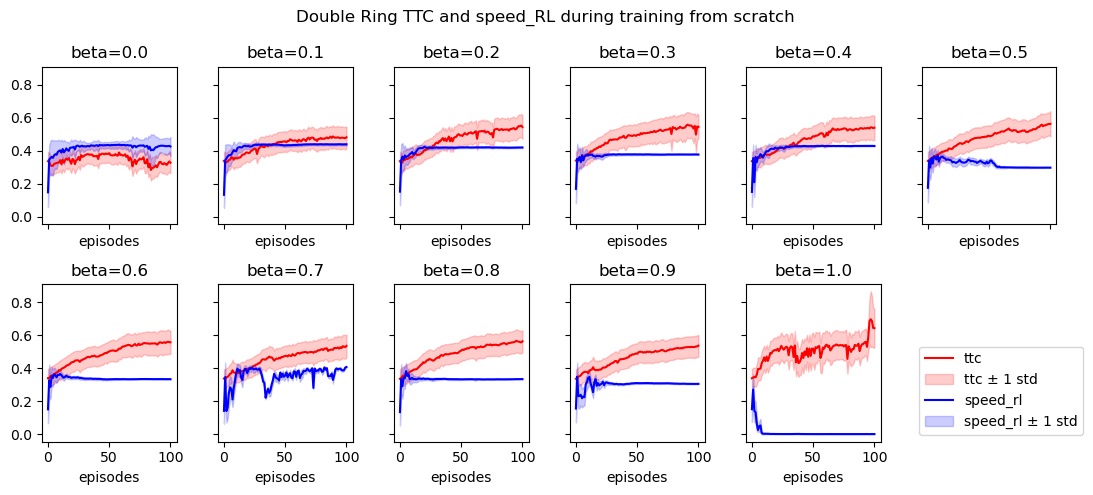

In [6]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(11, 5), sharex=True, sharey=True)
axs_flat = axs.flatten()
x = np.arange(101)

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')
    
    ttc_y, ttc_std = train_df['ttc_mean']/7, train_df['ttc_std']/7
    speed_y, speed_std = train_df['speed_rl']/10, train_df['speed_rl_std']/10
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ttc_y, color='red', label='ttc')
    ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
    ax.plot(x, speed_y, color='blue', label='speed_rl')
    ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_rl ± 1 std')
    
    ax.set_xlabel('episodes')

plt.suptitle('Double Ring TTC and speed_RL during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

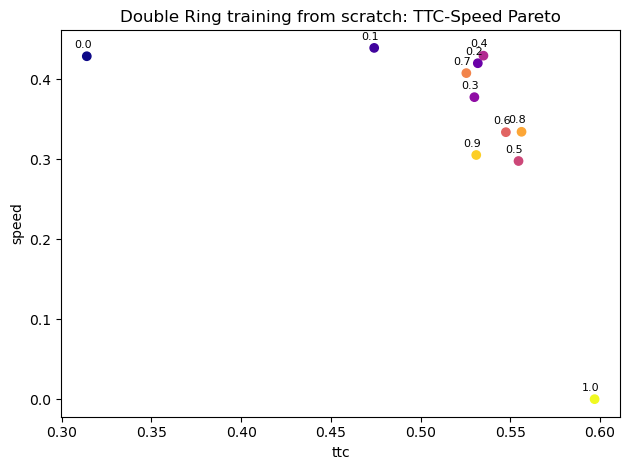

In [72]:
# plot pareto curve

ttcs = []
speeds = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    eval_df = pd.read_csv(f'{cur_dir}/eval.csv')
    
    ttcs += [np.mean(eval_df['ttc_mean'])/7]
    speeds += [np.mean(eval_df['speed_rl'])/10]
    
plt.scatter(ttcs, speeds, c=np.arange(11), cmap='plasma')

for i, (xi, yi) in enumerate(zip(ttcs, speeds)):
    plt.annotate(f'{i/10}', (xi, yi), textcoords="offset points", xytext=(-3,6),
                 ha='center', fontsize=8)

plt.title('Double Ring training from scratch: TTC-Speed Pareto')
plt.xlabel('ttc')
plt.ylabel('speed')
plt.tight_layout()
plt.show()

## figure eight

#### helper funcs

In [23]:
folder = 'pareto/figure_eight'

fe_testing_exp_dir = f'{folder}/testing'
Path(f'{fe_testing_exp_dir}').mkdir(parents=True, exist_ok=True)

def figure_eight_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        worker_kwargs=[{'radius':30}], 
        n_workers=40,
        n_rollouts_per_step=40,
        horizon=20000,
        lr_schedule='cosine',
        alg='TRPO',
        use_critic=False,
        gamma=0.999,
        beta=0,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/figure_eight.py {run_dir} "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "worker_kwargs={worker_kwargs}"'''
f''' "horizon={horizon}" "lr_schedule={lr_schedule}" "alg='{alg}'" "use_critic={use_critic}" "gamma={gamma}" "beta={beta}"'''
                  )
    return script_text

def figure_eight_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        e=100,
        radius=30,
        warmup_steps=1000,
        skip_stat_steps=8000,
        horizon=1000,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/figure_eight.py {run_dir} "e={e}" "radius={radius}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}"'''
                  )
    return script_text

##### testing

In [24]:
# train

output_logs = []

b=5
beta = b/10
cur_dir = f'{fe_testing_exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = figure_eight_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)
output_logs += [output_log_name]

File 'pareto/figure_eight/testing/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25473778
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


In [27]:
# verify successful train
verify_multiple_execution(output_logs) 
    
# eval
output_logs = []

b=5
beta = b/10
cur_dir = f'{fe_testing_exp_dir}/{beta}'
output_log_name = f'{cur_dir}/eval{beta}.log'
eval_script_text = single_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
eval_script_path = f'{cur_dir}/eval{beta}.sh'
create_file_with_contents(eval_script_path, eval_script_text)
out, err = submit_job(eval_script_path)
print(out, err)
output_logs += [output_log_name]

failed scripts: []
File 'pareto/figure_eight/testing/0.5/eval0.5.sh' created successfully with contents.
Submitted batch job 25474813
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


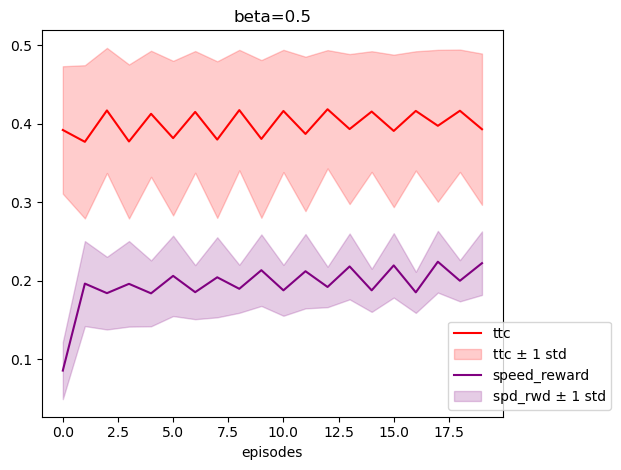

In [29]:
# plot training ttc vs speed for 0.5, see if ttc will converge

# x = np.arange(51)

b=5
beta = b/10
cur_dir = f'{fe_testing_exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']

# speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
# drac_y, drac_std = train_df['drac_mean'], train_df['drac_std']
# ssm_y = ttc_y-drac_y
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
# reward_y = train_df['reward_mean']

x = np.arange(len(speed_reward_y))


plt.title(f'beta={beta}')
plt.plot(x, ttc_y, color='red', label='ttc')
plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')

# plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.plot(x, drac_y, color='green', label='drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()

## intersection

## highway bottleneck

## highway ramp